# GADDS Area Detector Merging

This notebook demonstrates merging two area detectors using the `AreaDetectorMerger` class with two methods:
- **Data-driven**: Uses actual detector coverage for boundaries
- **Convex hull**: Creates geometric boundaries around overlap regions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from area_detector_merger import load_and_merge_detectors

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Load GFRM files and merge using both methods
gfrm_files = [
    r"test\20250709_S_MeO_B01_000.gfrm",
    r"test\20250709_S_MeO_B01_001.gfrm"
]

# Create merger and run both merging methods
merger = load_and_merge_detectors(gfrm_files, method='both', verbose=True)

  File "c:\Users\danielliu\Documents\git-local\gaddsconverter\gadds.py", line 89, in rowcol_to_angles
    nX, nY = self.image.dim1, self.image.dim2
  File "c:\Users\danielliu\Documents\git-local\gaddsconverter\gadds.py", line 89, in rowcol_to_angles
    nX, nY = self.image.dim1, self.image.dim2


Converting detector 0 to 2θ-γ space...
Converting detector 1 to 2θ-γ space...
=== Detector 0 Information ===
TITLE: 20250709_S_MeO
20250709_S_MeO
Alpha (2θ center): 20.00°
Distance: 22.45 cm
Detector center (x, y): (1003.7000122, 1022.0999756)
Pixel density (x, y): (147.0628052, 147.0628052) pixels/cm
Scale factor: 1.0
Offset: 0.0
Converted image shape: (512, 512)
2θ range: [2.46, 39.97]°
γ range: [-171.75, -8.29]°
=== end ===

=== Detector 1 Information ===
TITLE: 20250709_S_MeO
20250709_S_MeO
Alpha (2θ center): 30.00°
Distance: 22.45 cm
Detector center (x, y): (1003.7000122, 1022.0999756)
Pixel density (x, y): (147.0628052, 147.0628052) pixels/cm
Scale factor: 1.0
Offset: 0.0
Converted image shape: (512, 512)
2θ range: [12.46, 49.09]°
γ range: [-143.93, -36.20]°
=== end ===

=== Method 1: Data-Driven Weight Grid ===
Processing detector 0...
Processing detector 1...
Coverage analysis:
  Detector 0: 180,257 pixels
  Detector 1: 113,314 pixels
  Overlap region: 80,653 pixels
  Total cov

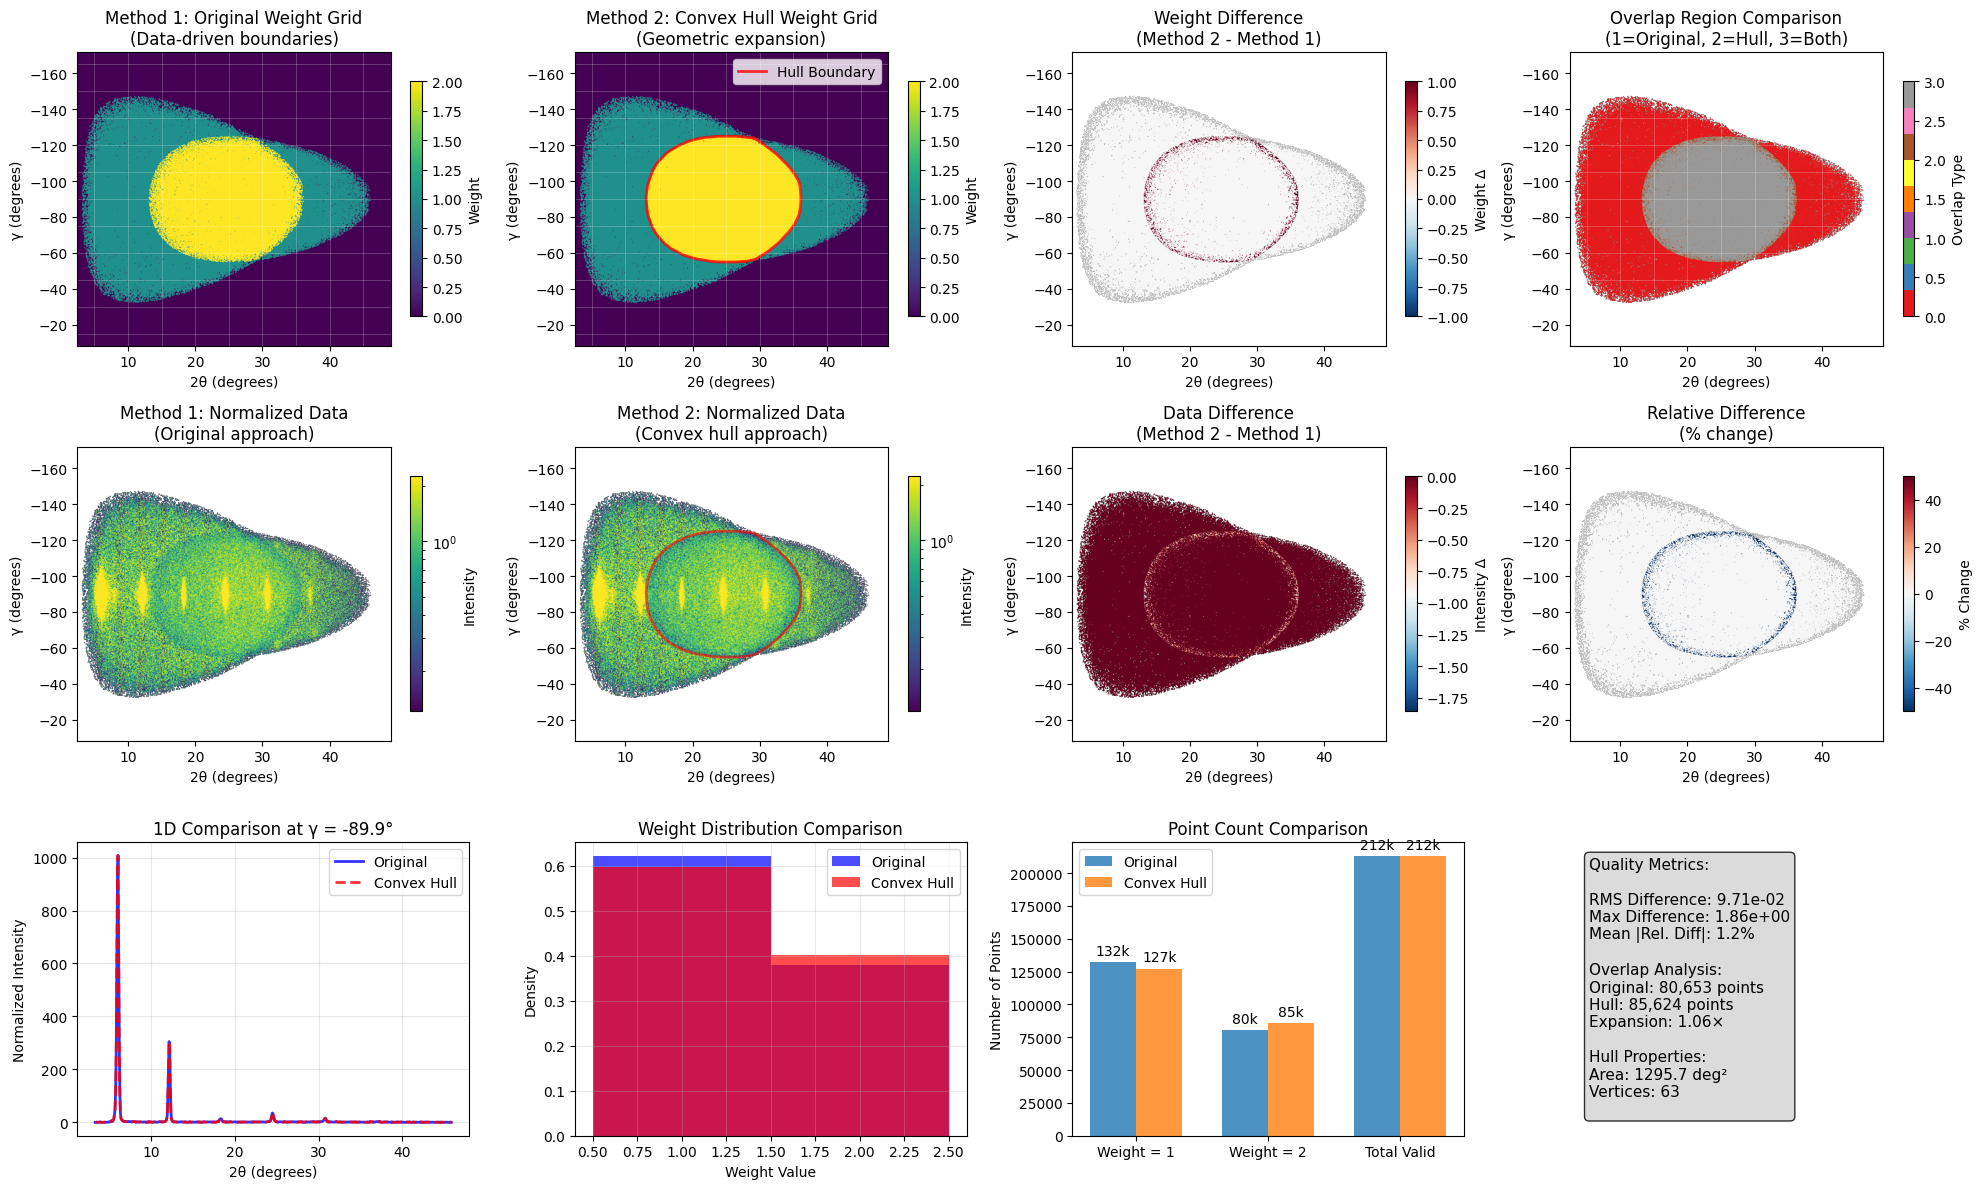

In [3]:
# Create comprehensive comparison plot
fig = merger.create_comparison_plot(figsize=(20, 12))
plt.show()

In [4]:
# Display quality metrics
try:
    metrics = merger.get_quality_metrics()
    print("=== Quality Metrics ===")
    for key, value in metrics.items():
        if isinstance(value, float):
            if 'difference' in key.lower():
                print(f"{key}: {value:.2e}")
            elif 'pct' in key.lower():
                print(f"{key}: {value:.1f}%")
            else:
                print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value:,}")
except Exception as e:
    print(f"Error calculating metrics: {e}")

# Access merged data
print("\n=== Merged Data Summary ===")
print(f"Data-driven method: {np.sum(merger.weight_grid > 0):,} valid pixels")
print(f"Convex hull method: {np.sum(merger.convex_hull_weight_grid > 0):,} valid pixels")
print(f"Overlap regions: {np.sum(merger.weight_grid == 2):,} → {np.sum(merger.convex_hull_weight_grid == 2):,} pixels")

=== Quality Metrics ===
rms_difference: 9.71e-02
max_difference: 1.86e+00
mean_relative_difference_pct: 1.17e+00
original_overlap_points: 80,653
hull_overlap_points: 85,624
expansion_factor: 1.06
hull_area_deg2: 1295.69
hull_vertices: 63

=== Merged Data Summary ===
Data-driven method: 212,918 valid pixels
Convex hull method: 212,918 valid pixels
Overlap regions: 80,653 → 85,624 pixels


In [5]:
# Set up AreaDetectorImageConverter with merged data
from gadds_reverse import AreaDetectorImageConverter

# Create converter instance
converter = AreaDetectorImageConverter()

# Calculate parameters
alpha_rad = np.deg2rad(25.0)  # Average of 20° and 30°
distance_cm = merger.area_detectors[0].distance  # 22.45 cm
density_xy = np.array(merger.area_detectors[0].densityXY)  # (147.0628052, 147.0628052)
detector_shape = (2048, 3072)  # Height x Width - twice as high as original

# Calculate center_xy scaled to detector size
# Original detectors were ~1024x1024, new is 2048x4096
# Center should be proportionally scaled
original_center = merger.area_detectors[0].centerXY
original_dim_x, original_dim_y = merger.area_detectors[0].image.shape[-1], merger.area_detectors[0].image.shape[-2]
scale_x = detector_shape[-1] / original_dim_x
scale_y = detector_shape[-2] / original_dim_y
center_xy = (original_center[0] * scale_x, original_center[1] * scale_y)

print("Setting up AreaDetectorImageConverter with:")
print(f"  alpha_rad: {alpha_rad:.6f} rad ({np.rad2deg(alpha_rad):.1f}°)")
print(f"  distance_cm: {distance_cm:.2f} cm")
print(f"  density_xy: {density_xy}")
print(f"  detector_shape: {detector_shape}")
print(f"  center_xy: {center_xy}")
print("  scale: 1, offset: 0")

# Set detector parameters
converter.set_detector_parameters(
    alpha_rad=alpha_rad,
    distance_cm=distance_cm,
    center_xy=center_xy,
    density_xy=density_xy,
    detector_shape=detector_shape,
    scale=1,
    offset=0
)

# print(merger.common_grid['twoth'])
# print(merger.common_grid['gamma'])


# Set converted data and coordinates (merger coordinates are already in degrees)
converter.set_converted_data_with_coordinates(
    data_converted=merger.normalized_data,
    gamma_coords=merger.common_grid['gamma'],
    twoth_coords=merger.common_grid['twoth']
)

print("\n✅ AreaDetectorImageConverter setup complete!")
print(f"   Merged data shape: {converter.data_converted.shape}")
print(f"   Valid pixels: {np.sum(converter.data_converted > 0):,}")
print(f"   2θ coordinate range: [{converter.indexes[1].min():.1f}°, {converter.indexes[1].max():.1f}°]")
print(f"   γ coordinate range: [{converter.indexes[0].min():.1f}°, {converter.indexes[0].max():.1f}°]")

Setting up AreaDetectorImageConverter with:
  alpha_rad: 0.436332 rad (25.0°)
  distance_cm: 22.45 cm
  density_xy: [147.0628052 147.0628052]
  detector_shape: (2048, 3072)
  center_xy: (1505.5500183, 1022.0999756)
  scale: 1, offset: 0

✅ AreaDetectorImageConverter setup complete!
   Merged data shape: (776, 651)
   Valid pixels: 212,918
   2θ coordinate range: [2.5°, 49.1°]
   γ coordinate range: [-171.7°, -8.3°]


Testing reverse conversion...
Reverse conversion results:
  Original merged data shape: (776, 651)
  Converted detector image shape: (2048, 3072)
  Valid pixels in detector image: 4,233,701


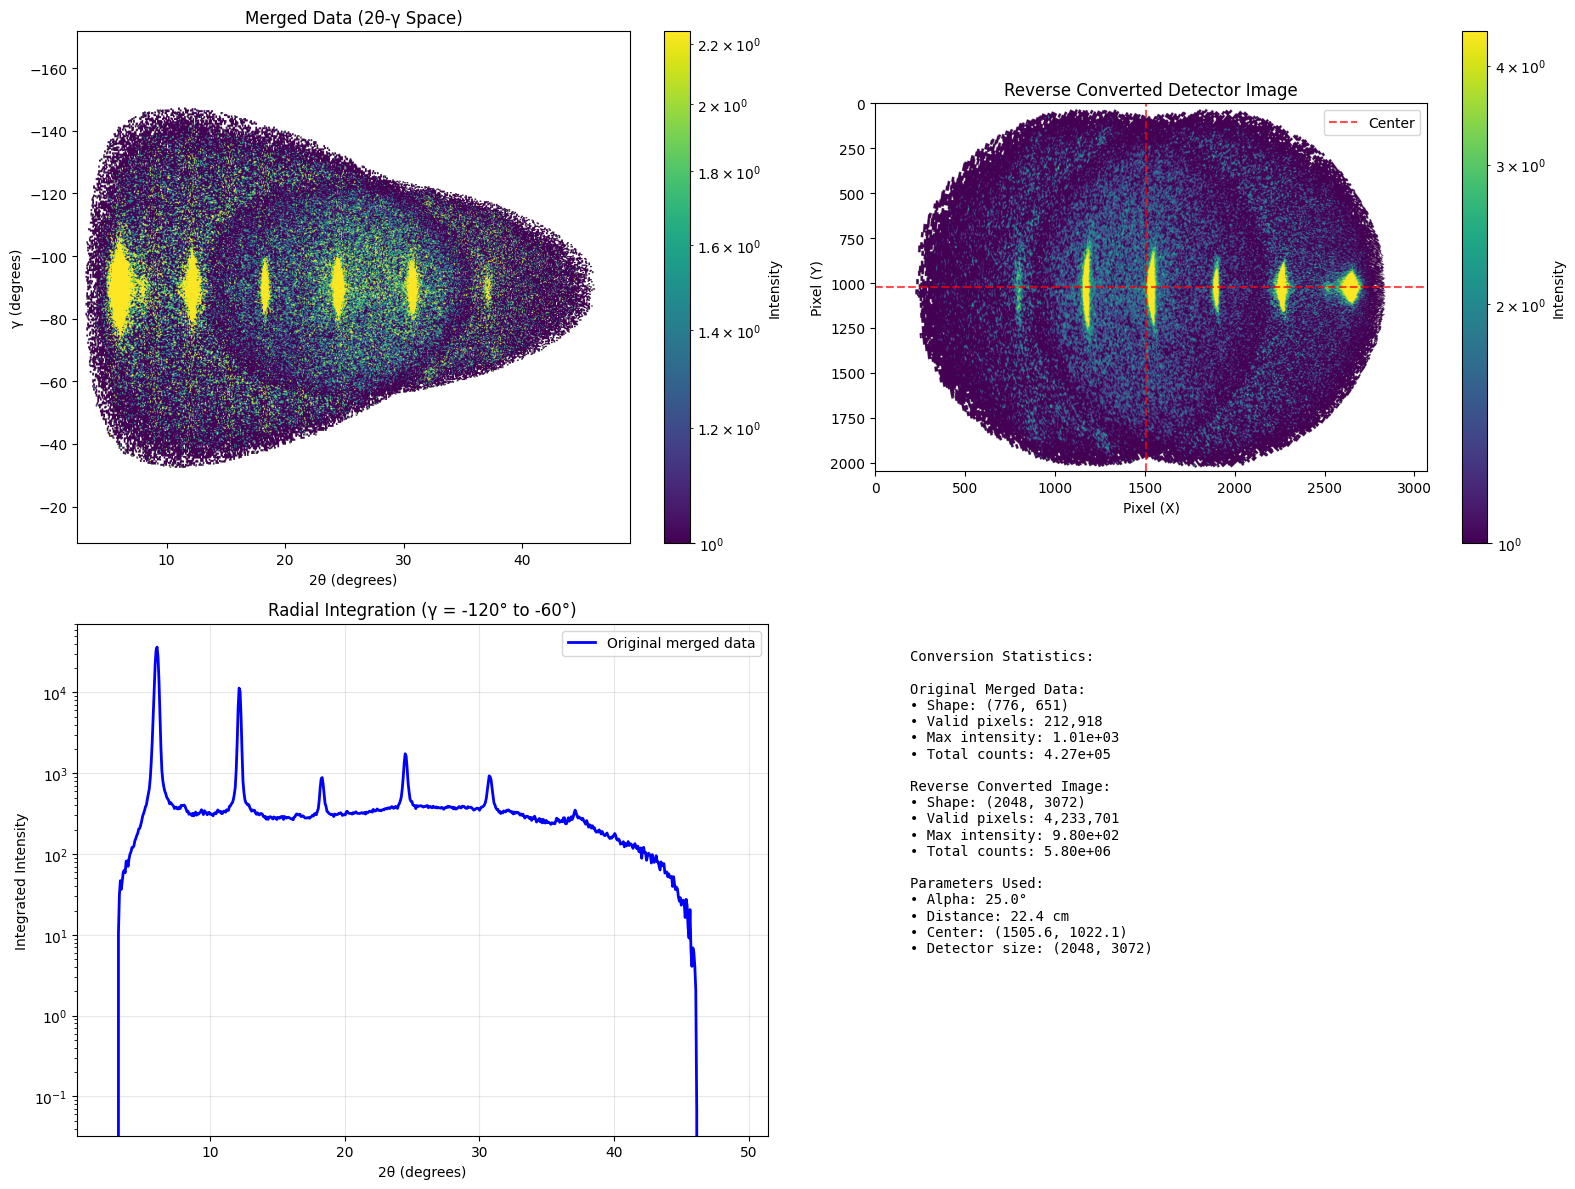

✅ Reverse conversion test completed!


In [6]:
# Test reverse conversion and create visualization
print("Testing reverse conversion...")

# Convert back to detector space with custom resolution
test_detector_image = converter.convert_back_to_detector(n_col=detector_shape[1], n_row=detector_shape[0], method='linear')

print("Reverse conversion results:")
print(f"  Original merged data shape: {converter.data_converted.shape}")
print(f"  Converted detector image shape: {test_detector_image.shape}")
print(f"  Valid pixels in detector image: {np.sum(test_detector_image > 0):,}")

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Original merged data (2θ-γ space)
im1 = axes[0,0].imshow(
    converter.data_converted, 
    cmap='viridis',
    norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=np.percentile(converter.data_converted[converter.data_converted > 0], 95)),
    origin='upper',
    extent=[converter.indexes[1].min(), converter.indexes[1].max(), 
            converter.indexes[0].max(), converter.indexes[0].min()],
    aspect='auto'
)
axes[0,0].set_title('Merged Data (2θ-γ Space)')
axes[0,0].set_xlabel('2θ (degrees)')
axes[0,0].set_ylabel('γ (degrees)')
plt.colorbar(im1, ax=axes[0,0], label='Intensity')

# 2. Converted detector image
im2 = axes[0,1].imshow(
    test_detector_image,
    cmap='viridis', 
    norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=np.percentile(test_detector_image[test_detector_image > 0], 99)),
    origin='upper'
)
axes[0,1].set_title('Reverse Converted Detector Image')
axes[0,1].set_xlabel('Pixel (X)')
axes[0,1].set_ylabel('Pixel (Y)')
# Add center cross
axes[0,1].axhline(y=center_xy[1], color='red', linestyle='--', alpha=0.7, label='Center')
axes[0,1].axvline(x=center_xy[0], color='red', linestyle='--', alpha=0.7)
axes[0,1].legend()
plt.colorbar(im2, ax=axes[0,1], label='Intensity')

# 3. Radial integration comparison
gamma_mask = (converter.indexes[0] >= -120) & (converter.indexes[0] <= -60)
radial_original = np.sum(converter.data_converted[gamma_mask, :], axis=0)
axes[1,0].plot(converter.indexes[1], radial_original, 'b-', linewidth=2, label='Original merged data')
axes[1,0].set_title('Radial Integration (γ = -120° to -60°)')
axes[1,0].set_xlabel('2θ (degrees)')
axes[1,0].set_ylabel('Integrated Intensity')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_yscale('log')

# 4. Statistics comparison
axes[1,1].axis('off')
stats_text = f"""Conversion Statistics:

Original Merged Data:
• Shape: {converter.data_converted.shape}
• Valid pixels: {np.sum(converter.data_converted > 0):,}
• Max intensity: {np.max(converter.data_converted):.2e}
• Total counts: {np.sum(converter.data_converted):.2e}

Reverse Converted Image:
• Shape: {test_detector_image.shape}
• Valid pixels: {np.sum(test_detector_image > 0):,}
• Max intensity: {np.max(test_detector_image):.2e}
• Total counts: {np.sum(test_detector_image):.2e}

Parameters Used:
• Alpha: {np.rad2deg(alpha_rad):.1f}°
• Distance: {distance_cm:.1f} cm
• Center: ({center_xy[0]:.1f}, {center_xy[1]:.1f})
• Detector size: {detector_shape}
"""
axes[1,1].text(0.05, 0.95, stats_text, transform=axes[1,1].transAxes,
               verticalalignment='top', fontfamily='monospace', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Reverse conversion test completed!")